# Set de Datos

In [1]:
#postulantes_edu = sc.textFile('/home/luupesado/7506_Datos/2018/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv', 10)
postulantes = sc.textFile('/home/luupesado/7506_Datos/2018/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv', 10)#.option("header", true)
#vistas = sc.textFile('/home/luupesado/7506_Datos/2018/datos_navent_fiuba/fiuba_3_vistas.csv', 10)
#postulaciones = sc.textFile('/home/luupesado/7506_Datos/2018/datos_navent_fiuba/fiuba_4_postulaciones.csv', 10)

# Ejercicio 1

Encontrar los 5 anuncios cuya tasa de conversión (postulaciones al anuncio sobre visitas totales al anuncio) es la más alta.

Nota: Tener en cuenta que es posible que por ejemplo un anuncio con una visita y una postulación quede primero. Para evitar este inconveniente, tomar únicamente los avisos que poseen al menos un 25% de las visitas promedio que poseen los avisos. Por ejemplo, si el promedio de visitas de los avisos es 100, tomar solo los avisos que tengan al menos 25 visitas.

Nota2: Tener en cuenta también que los datos de vistas están incompletos. Solo podrá obtenerse la tasa de conversión para el período donde se tengan ambas informaciones (postulaciones y vistas).


In [3]:
postulaciones.take(5)

[u'idaviso,idpostulante,fechapostulacion',
 u'1112257047,NM5M,2018-01-15 16:22:34',
 u'1111920714,NM5M,2018-02-06 09:04:50',
 u'1112346945,NM5M,2018-02-22 09:04:47',
 u'1112345547,NM5M,2018-02-22 09:04:59']

In [3]:
vistas.take(5)

[u'idAviso,timestamp,idpostulante',
 u'1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z',
 u'1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR',
 u'1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd',
 u'1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv']

Averiguo para que periodo tengo tanto vistas como postulaciones, haciendo caso a la Nota 2

In [12]:
vistas_periodo = vistas.map(lambda x: x.split(',')).map(lambda z: z[1].split('T')).map(lambda y: (y[0],1)).reduceByKey(lambda a,b: a+b).takeOrdered(60, lambda f: f[0])

In [13]:
vistas_periodo

[(u'2018-02-23', 67747),
 (u'2018-02-24', 90349),
 (u'2018-02-25', 105245),
 (u'2018-02-26', 240783),
 (u'2018-02-27', 230947),
 (u'2018-02-28', 226826),
 (u'timestamp', 1)]

Tengo vistas solo desde el 23/2 al 28/2

In [15]:
postulaciones_periodo = postulaciones.map(lambda x: x.split(',')).map(lambda y: (y[2],1)).reduceByKey(lambda a,b: a+b).takeOrdered(5, lambda f: f[0])

In [16]:
postulaciones_periodo

[(u'2018-01-15 00:00:01', 1),
 (u'2018-01-15 00:00:02', 1),
 (u'2018-01-15 00:00:09', 1),
 (u'2018-01-15 00:00:10', 1),
 (u'2018-01-15 00:00:11', 1)]

Las Postulaciones comienzan el 15/1

Ahora voy a comenzar a resolver el ejercicio obteniendo la cantidad de visitas que tuvo cada aviso

In [3]:
cant_vistas = vistas.map(lambda x: x.split(',')).map(lambda y: (y[0], 1)).reduceByKey(lambda a,b: a+b)

In [4]:
cant_vistas.take(5)

[(u'1112366334', 557),
 (u'1112269789', 76),
 (u'1112312760', 84),
 (u'1112288001', 48),
 (u'1112192023', 8)]

Ahora calculo el promedio de la cantidad de visitas de cada aviso, haciendo caso a la Nota1 y evitando así equivocarme con "la ecuación más peligrosa de la historia", filtro los que tienen menos de un %25 de las visitas promedio.

In [5]:
promedio = cant_vistas.map(lambda x: (1, x[1])).reduceByKey(lambda a,b: a+b)

In [6]:
promedio.take(1)[0]

(1, 961898)

In [7]:
promedio = promedio.take(1)[0][1]/cant_vistas.count()

In [8]:
promedio

128

In [9]:
cant_vistas = cant_vistas.filter(lambda x: x[1]>(promedio/4))

Ahora calculo la cantidad de postulaciones para cada publicacion en ese período

In [17]:
cant_postulaciones = postulaciones.map(lambda x: x.split(',')).map(lambda y: (y[0], y[2].split(' ')[0], 1)).filter(lambda z: z[1]>='2018-02-23' and z[1]<='2018-02-28').map(lambda v: (v[0], v[2])).reduceByKey(lambda a,b: a+b)

In [18]:
cant_postulaciones.take(5)

[(u'1112366334', 227),
 (u'1112269789', 19),
 (u'1112312760', 43),
 (u'1112312098', 18),
 (u'1112323355', 26)]

Ahora uno la cantidad de postulaciones con la cantidad de visitas para cada sitio para poder calcular la tasa de conversión. Corresponde un inner join ya que la consigna especifica que la tasa se calcule para los avisos que tengan tanto visitas como postulaciones.

In [28]:
tasa = cant_postulaciones.join(cant_vistas).map(lambda x: (x[0], float(x[1][0])/float(x[1][1])))

In [27]:
 cant_postulaciones.join(cant_vistas).take(5)

[(u'1112366334', (227, 557)),
 (u'1112312760', (43, 84)),
 (u'1112323355', (26, 132)),
 (u'1112269789', (19, 76)),
 (u'1112335406', (142, 414))]

In [29]:
tasa.take(5)

[(u'1112366334', 0.40754039497307004),
 (u'1112312760', 0.5119047619047619),
 (u'1112323355', 0.19696969696969696),
 (u'1112269789', 0.25),
 (u'1112335406', 0.34299516908212563)]

In [58]:
mayor_tasa = tasa.takeOrdered(5, lambda x: -x[1])

In [62]:
rdd_tasa = sc.parallelize(mayor_tasa)

In [64]:
rdd_tasa.take(5)

[(u'1112355348', 2.0912052117263844),
 (u'1112365531', 1.6677814938684503),
 (u'1112343233', 1.5833333333333333),
 (u'1112299671', 1.5633802816901408),
 (u'1112357810', 1.4901960784313726)]

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [103]:
bar_ids

[u'1112355348', u'1112365531', u'1112343233', u'1112299671', u'1112357810']

In [104]:
bar_tasa

[2.0912052117263844,
 1.6677814938684503,
 1.5833333333333333,
 1.5633802816901408,
 1.4901960784313726]

<Container object of 5 artists>

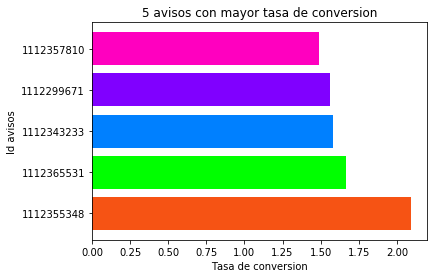

In [116]:
bar_ids = rdd_tasa.map(lambda x: x[0]).take(5)
bar_tasa = rdd_tasa.map(lambda y: y[1]).take(5)
fig, ax = plt.subplots()
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(bar_ids)
ax.set_title('5 avisos con mayor tasa de conversion')
ax.set_xlabel('Tasa de conversion')
ax.set_ylabel('Id avisos')
ax.barh([0,1,2,3,4], bar_tasa, color = ['#f65314', '#00ff00', '#0080ff', '#8000ff', '#ff00bf'])

# Ejercicio 2

Indicar la distribución de la edad de los postulates

In [2]:
postulantes.take(5)

[u'idpostulante,fechanacimiento,sexo',
 u'NM5M,1970-12-03,FEM',
 u'5awk,1962-12-04,FEM',
 u'ZaO5,1978-08-10,FEM',
 u'NdJl,1969-05-09,MASC']

In [3]:
import datetime as dt

In [4]:
fecha_str = u'1995-08-17'
fecha = dt.datetime.strptime(fecha_str, "%Y-%m-%d")
fecha.year
edad = fecha_str

In [4]:
def strdate_to_age(string):
    try:
        date = dt.datetime.strptime(string, "%Y-%m-%d")
        today = dt.datetime(2018, 4, 1)
        edad = today.year - date.year
        if today.month >= date.month and today.day >= date.day:
            edad = edad +1
        return edad
    except:
        return 0

In [5]:
postulantes_edad = postulantes.map(lambda x: x.split(',')).filter(lambda x: x[0] != 'idpostulante').map(lambda y: (strdate_to_age(y[1]), 1)).filter(lambda z: (z[0] <100 and z[0]>16))


In [6]:
postulantes_edad.take(5)

[(48, 1), (56, 1), (40, 1), (49, 1), (37, 1)]

In [7]:
postulantes_edad_count = postulantes_edad.reduceByKey(lambda a, b: a+b)

In [8]:
lista_edad_cantidad = postulantes_edad_count.takeOrdered(61, lambda a: a[0])

In [9]:
lista_edad_cantidad

[(18, 566),
 (19, 3625),
 (20, 6449),
 (21, 8503),
 (22, 9927),
 (23, 10874),
 (24, 11586),
 (25, 11680),
 (26, 11804),
 (27, 11923),
 (28, 11099),
 (29, 9890),
 (30, 9179),
 (31, 8309),
 (32, 7643),
 (33, 6679),
 (34, 5879),
 (35, 5450),
 (36, 5024),
 (37, 4661),
 (38, 4189),
 (39, 3883),
 (40, 3384),
 (41, 2933),
 (42, 2641),
 (43, 2356),
 (44, 1979),
 (45, 1692),
 (46, 1564),
 (47, 1462),
 (48, 1277),
 (49, 1098),
 (50, 944),
 (51, 874),
 (52, 751),
 (53, 662),
 (54, 646),
 (55, 552),
 (56, 478),
 (57, 447),
 (58, 376),
 (59, 286),
 (60, 233),
 (61, 182),
 (62, 163),
 (63, 96),
 (64, 73),
 (65, 37),
 (66, 30),
 (67, 19),
 (68, 30),
 (69, 12),
 (70, 9),
 (71, 7),
 (72, 2),
 (74, 3),
 (75, 2),
 (76, 3),
 (77, 1),
 (79, 1),
 (97, 1)]

In [38]:
edades = []
count = []
edad = 18
i = 0
while edad <= lista_edad_cantidad[-1][0]:
    edades.append(edad)
    if lista_edad_cantidad[i][0] == (edad):
        count.append(lista_edad_cantidad[i][1])
        i = i+1
        edad = edad + 1
    else:
        count.append(0)
        edad = edad + 1
        
edades

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97]

<Container object of 80 artists>

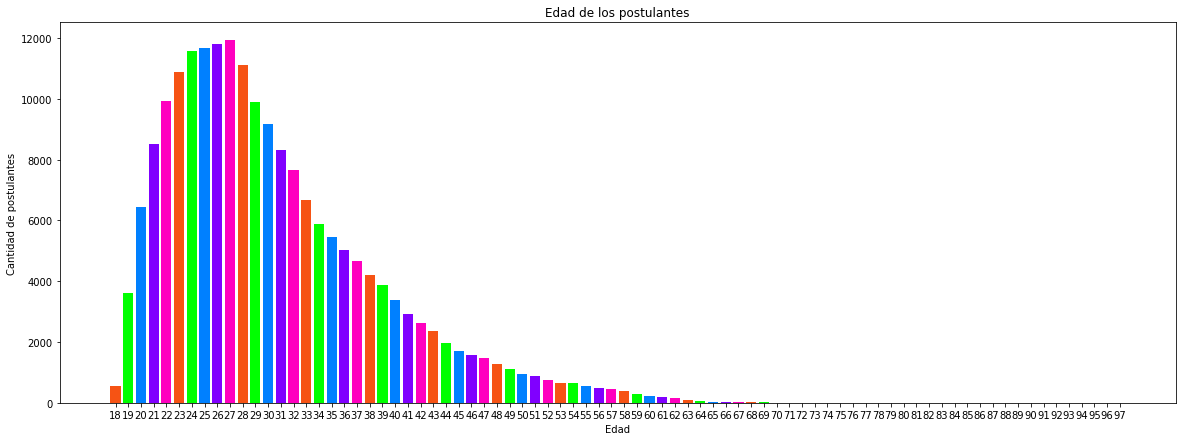

In [41]:
fig, ax = plt.subplots(figsize = (20,7))
width = 0.35
ax.set_xticks(np.arange(len(edades)) + width)
ax.set_xticklabels(edades)
ax.set_title('Edad de los postulantes')
ax.set_xlabel('Edad')
ax.set_ylabel('Cantidad de postulantes')
ax.bar(np.arange(len(edades))+width, count, color = ['#f65314', '#00ff00', '#0080ff', '#8000ff', '#ff00bf'])

In [14]:
97-18

79